In [25]:
import pickle
import os 
import cv2
import glob
import matplotlib.pyplot as plt

from pprint import pprint

# select one of the multiple GPU cards on the server.
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set GPU if multiple present


In [42]:
'''
This code is developed and run on at least two machines
Here we setup the default paths for each machine.
Eventually we must find a more general way to do this.
'''

host = os.getenv('HOSTNAME')
if host==None:      # pop os dees not have HOSTNAME defined by default.
    host = "pop"
print(host)

if "dsigpu" in host:
    pklDir = '/home/dsi/aryeh/data/mia/pkl/'
    modelDir = '/home/dsi/aryeh/data/mia/trained_models/'
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata = '/home/dsi/aryeh/data/plants/unCropped/resized/'
    predictionFolder = '/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/'
elif "pop" in host:
    pklDir = '/media/amw/TOSHIBA EXT/alerding/models/pkl/'
    modelDir = '/media/amw/TOSHIBA EXT/alerding/models/gpuModels/'
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata =  '/media/amw/TOSHIBA EXT/alerding/annotated/notCroppedLabels2/resized/'
    predictionFolder = '/media/amw/TOSHIBA EXT/alerding/Harvest 8 Orange 5,7 Oct 17.r/vertical/'
else:
    pklDir = None
    modelDir = None 
    modelname = "unetDensnet201_2023-01-24_08-17-37"
    trainingdata = None
    predictionFolder = None

dsigpu05


In [36]:
# the pkl directory contains the pkl files that hold a DeepLearning structure that defines the DL model
# If the dl object is directly created then the pkl file is not needed.
pklDir = input('Enter pkl path or use default\n') or pklDir

# the model directory will receive the trained model
modelDir = input('Enter model output directory or default\n') or modelDir
    
loadweights = None

# modelname is the name of the pkl file without its pkl  extension.
# a pkl file holds a data structure or object. IN this case, it is expected to hold a DeepLearning object that was saved
# using File>Save DL Object... in mianalyzer. 
# If the dl object is directly created then this is not needed.
modelname = input("Enter modelname without extension or use default\n") or modelname
# stem, pop, background and unlabeled
# We should have a single cell where aall of the model and training parameters are set
numclasses = 4

# trainingdata is a directory that holds the annotated images. The labels must be in trainingdata/Segmentation_labels/
# and they must be npz files.
trainingdata = input("Path to folder containing training images, or use default\n") or trainingdata
validationdata = None

print("model: ", modelname)

BackBone = input("input backbone or enter for default\n") or 'densenet201'

strEpochs = input("input number of epochs or enter to use the predefined value in a pkl file\n") or '0'

epochs = int(strEpochs)


model:  unetDensnet201_2023-01-24_08-17-37_ep100


In [37]:
'''
This is from the version that reads the dl object from a pkl file.
'''

print('load settings')
#filehandler = open(modelname + '.pkl', 'rb')
filehandler = open(pklDir + modelname + '.pkl', 'rb')

dl = pickle.load(filehandler)
print(dl.epochs)
if epochs != 0:
    dl.epochs = epochs
if dl.Mode.backbone != BackBone:
    dl.Mode.backbone = BackBone
pprint(vars(dl.Mode))


load settings
100
{'architecture': 'UNet',
 'backbone': 'densenet201',
 'loss': <dl.loss.segmentation_losses.SegmentationLosses object at 0x7f6fd005b890>,
 'metric': <dl.metric.segmentation_metrics.SegmentationMetrics object at 0x7f6fd005bc50>,
 'parent': <dl.DeepLearning.DeepLearning object at 0x7f6fd3c02350>,
 'preprocessingfnc': None,
 'pretrained': True,
 'type': <dlMode.Segmentation: 2>}


In [16]:
'''
Creates the dl object. Default is UNet, resnet152, 100 epochs,
scaleFactor is 0.5, and learning rate is 0.001.
All the other parmeters are the defaults of the dl object.

Unfortunately, the predictions of the the models using this dl object are not accurate, 
even though the dl and dl.Mode paparmeters are the same. There must be other parameters
that I am not setting correclty in the manually created dl object.
'''

print(os.getcwd())


from dl.DeepLearning import *
def createDL( epochs=100, scaleFactor=0.5, learning_rate = 0.001, backbone = 'densenet201'):
    dl = DeepLearning()
    dl.epochs = epochs
    dl.worker = 6
    dl.ImageScaleFactor = scaleFactor
#    dl.Mode = Segmentation()
    dl.learning_rate = learning_rate
    dl.Mode.architecture = 'UNet'
    dl.Mode.backbone = backbone
    return dl

/home/dsi/aryeh/git/miaHeadless/mia


In [17]:
'''
create the dl object and verify that it is initialized. 
'''
if epochs == 0:   # if there is no predefined value, default to 50
    epochs = 50 
dl = createDL( epochs, scaleFactor=0.5, learning_rate = 0.002, backbone = BackBone)
pprint(vars(dl))

{'architecture': 'UNet',
 'backbone': 'densenet201',
 'loss': <dl.loss.segmentation_losses.SegmentationLosses object at 0x7f8574038090>,
 'metric': <dl.metric.segmentation_metrics.SegmentationMetrics object at 0x7f85200666d0>,
 'parent': <dl.DeepLearning.DeepLearning object at 0x7f870ca76f90>,
 'preprocessingfnc': None,
 'pretrained': True,
 'type': <dlMode.Segmentation: 2>}


In [31]:
'''
Run this cell if you want to save the dl object as a pkl file
'''

pklFileHandler = open(pklDir+modelname+'_ep'+str(dl.epochs) + '.pkl','wb')
#import sys
#print(sys.getrecursionlimit())
#sys.setrecursionlimit(4*sys.getrecursionlimit())
#print(sys.getrecursionlimit())

hed = dl.hed
dl.hed = None
model = dl.Model
dl.Model = None
pickle.dump(dl, pklFileHandler)
dl.hed = hed
dl.Model = model



In [38]:


# pod, stem, background, and unlabeled (for deleaved soybean plants)
numClasses =4

print('init model')
dl.initModel(numclasses)

dl.Model = dl.Mode.getModel(numClasses, 3)

print('load model')
if loadweights is not None:
    dl.Model.load_weights(loadweights)

print(dl.initialized)

init model
load model
True


In [39]:
'''
Here we  do the training
'''
        
if dl.initialized:
    print('start training')
    dl.initData_StartTraining(trainingdata, validationdata)
    print('training finished')
else:
    print('could not initialize model')
            
print('saving weights')
modelname=dl.Mode.architecture+'_'+dl.Mode.backbone
dl.Model.save_weights(modelDir+modelname+'_ep'+str(dl.epochs) + '.h5')
print('saving training data')
dl.saveTrainingRecord(modelDir+modelname+'_ep'+str(dl.epochs) +'.csv')
#   print('saving model')
#   dl.Model.save(modelDir+'full')
    



start training
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
139/139 [==============================] - 51s 219ms/step - loss: 0.0088 - pixel_accuracy: 221371.6765 - val_loss: 0.0803 - val_pixel_accuracy: 264533.1562
Epoch 2/50
139/139 [==============================] - 25s 175ms/step - loss: 0.0066 - pixel_accuracy: 205709.1195 - val_loss: 0.0673 - val_pixel_accuracy: 143524.3750
Epoch 3/50
139/139 [==============================]

In [40]:
%matplotlib inline


31
/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.3.jpg


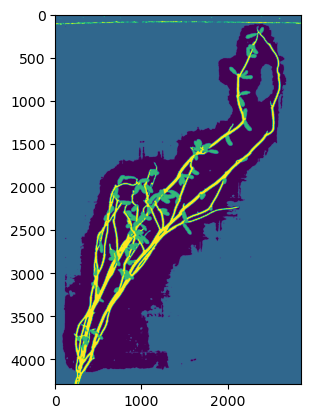

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.305.2.jpg


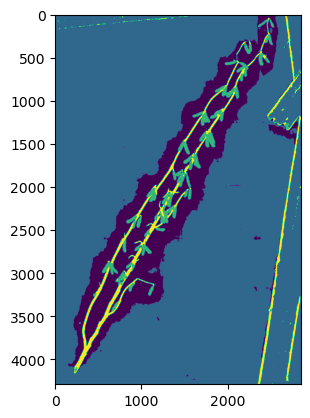

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.4.b.jpg


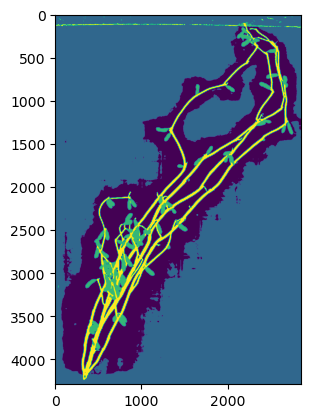

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.308.4.jpg


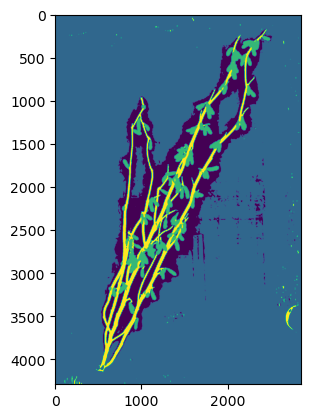

/home/dsi/aryeh/data/plants/Harvest8Orange5_7Oct17/OR7.104.2.b.jpg


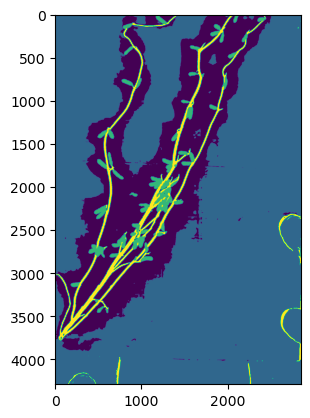

In [41]:
# This cell does a prediction on a directory of jpg images (could be any type, but that is what I have).
# predictionFolder contains the images which ill be predicted, and a subdirectory with the modelname will be created
# to hold the predicted segmentation.

predictionFolder = input('Enter folder for prediction or use default\n')  or predictionFolder
outputPath = predictionFolder + modelname+'_ep'+str(dl.epochs)+'/'
try:
    os.mkdir(outputPath)
except FileExistsError:
    pass
files = glob.glob(predictionFolder + '*.jpg')
print(len(files))

# If we do not want to process the entire folder, we can limit the number of processed image to count. 
count = 0
for i in files:
    print(i)
    img = cv2.imread(i)
    prediction = dl.Mode.PredictImage(img)
    plt.figure(count)
    plt.imshow(prediction)
    plt.show()
    cv2.imwrite(outputPath+'segmented_'+os.path.basename(i).replace('jpg', 'png'), prediction)
    count += 1
    if count > 4:
       break
    



In [ ]:
# I was checking why repeated runs of the prediction produced different reauslts. One possibility is that
# I need to reset the DL object between runs. But I am not sure about this.
print(dl.Model)
dl.cleanMemory()